In [1]:
import cv2
import numpy as np
from PIL import Image
from pytesseract import *
import re
from matplotlib import pyplot as plt

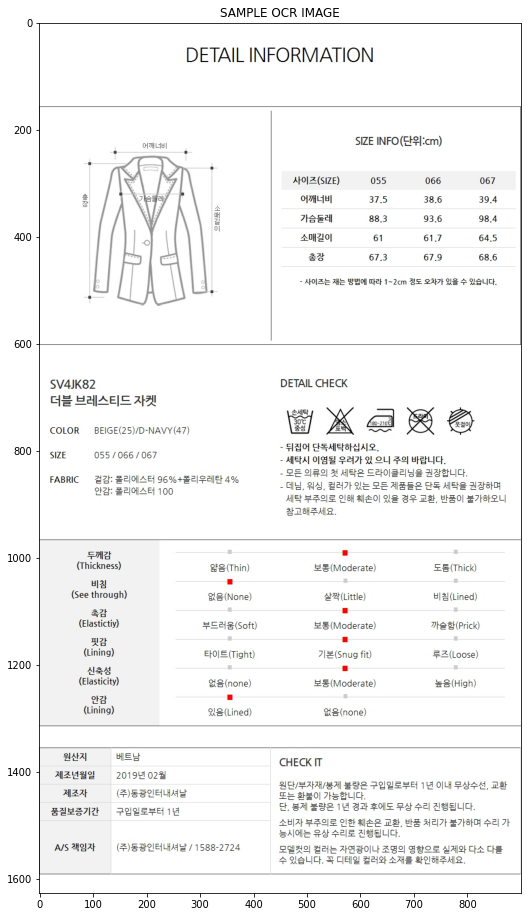

In [2]:
# 이미지 읽기
# img is in BGR format if the underlying image is a color image
# img = cv2.imread('tests/data/ocr_kor_test.jpg', 1)
# img = cv2.imdecode(np.fromfile('tests/data/ocr테스트이미지.jpg', dtype=np.uint8), cv2.IMREAD_UNCHANGED)
 
# # 이미지 화면에 표시
# cv2.imshow('Test Image', img)
# cv2.waitKey(0)
# # 이미지 윈도우 삭제
# cv2.destroyAllWindows()

image = cv2.imread('tests/data/ocr_kor_test.jpg')
b,g,r = cv2.split(image)
rgb_img = cv2.merge([r,g,b])

plt.figure(figsize=(20,16))
plt.imshow(rgb_img)
plt.title('SAMPLE OCR IMAGE')
plt.show()


In [3]:
# OpenCV OCR and text recognition
# 이미지 파일을 불러옵니다.
# img = Image.open('tests/data/ocr테스트이미지.jpg')
img_cv = cv2.imdecode(np.fromfile('tests/data/ocr테스트이미지.jpg', dtype=np.uint8), cv2.IMREAD_UNCHANGED)
# cv2.imshow('image', img_cv)
# By default OpenCV stores images in BGR format and since pytesseract assumes RGB format,
# we need to convert from BGR to RGB format/mode:
# img_rgb = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
# OR
img_rgb = Image.frombytes('RGB', img_cv.shape[:2], img_cv, 'raw', 'BGR', 0, 0)

print(pytesseract.image_to_string(img_rgb))


In [4]:
# Adding custom options
custom_config = r'--oem 3 --psm 6'

In [6]:
# 불러들인 이미지 파일을 pytesseract를 이용하여 text로 변환시킵니다.
text = pytesseract.image_to_string(img_rgb,lang='kor', config=custom_config)#영어면 lang='euc'

In [7]:
# 해당 이미지를 출력해봅니다.
print(text)

보시는 것 처럼 이미지를 텍스트화 시킨 것을 볼 수 있습니다. 그렇다면 이미지를 텍스트화 시키기 성공?

 

물론, 성공이라고 할 수 있습니다. 하지만 이렇게 정제되지 않은 데이터를 어떻게 가만히 있을 수가 있겠나요. 당연히 해당 데이터를 정제된 상태로 옮겨보고자 합니다. 제가 하려는 것은 해당 사진의 사이즈 정보만 출력해서 dataframe화 시키는 작업까지 진행하겠습니다.



In [ ]:
# 먼저 너무 공백이 많기 때문에 단넘기기(\n)를 기준으로 text를 구분해줍니다.
size_table = re.split('\n',text)
size_table

size_table를 확인해 보시면 리스트 형식으로 단넘기기를 기준으로 text가 구분되어 있는 것을 확인할 수 있습니다.

In [ ]:
# 다음으로 사이즈정보를 뽑으려 하는 것이므로 사이즈 정보가 담긴 text를 확인한 뒤 매칭시켜 사이즈 정보만 담긴 text를 추출합니다

matchers = ['사이즈(526)','어깨너비','가슴둘레','소매길이','총장']
size = [s for s in size_table if any(xs in s for xs in matchers)]
size

size를 확인해보면 리스트 형식으로 사이즈 정보만 추출된 것을 확인할 수 있습니다.

 

5. 제가 말씀드린 dataframe형식으로 만들기 위해 "정규표현식"을 사용하여 데이터를 정제했습니다. 여기서 "정규표현식'은 한번쯤은 공부하시길 추천드립니다. 시간이 난다면 정규표현식에 대해서 정리해 보는 시간도 가져 보겠습니다!

In [ ]:
import pandas as pd
size2 = []
for i in range(len(size)):
    size2.append(size[i].split())
    
if '총장' and '소매길이' and '어깨너비' and '가슴둘레' not in size2[1][0] + size2[2][0]+size2[3][0]+size2[4][0]:
    pass
else:
    match = re.match(r"([가-힣]+)([(0-9].+)", size2[0][0], re.I)
    if match:
        items = match.groups()
    size2[0][0] = items[0]

    size3 = list(map(list, zip(*size2))) #리스트를 transpose하는 법
    #import numpy as np
    #np.array(a).T.tolist() - 똑같은 방법  -> array 변환 -> 전치 -> tolist
    df_size = pd.DataFrame(size3[1:], columns = size3[0])
    
size2

사이즈별로 쉽게 정리하기 위해서 추출한 size를 split()를 사용하여 반복문을 통해 리스트로 붙여줍니다.

위의 리스트를 보면 필요없는 단어가 섞여있는 것을 확인할 수 있습니다.저희가 필요한 것은 사이즈와 사이즈별로 수치 이므로 "1는몰라", "흥" 등의 단어를 없애야 합니다. 따라서 그 작업을 진행해 보겠습니다.

In [ ]:
size3=[]
for i in range(len(size2)):
    if len(size2[i]) == len(size2[0]):
        size3.append(size2[i])
    else:
        diff = len(size2[i]) - len(size2[0])
        size3.append(size2[i][diff:])
        
size3

6. 이제 마지막 작업으로 dataframe을 만들어 볼텐데요. 위의 형식 그대로 만들기 보다는 카테고리가 column으로 있는 것이 낫다고 생각했습니다. 따라서 list를 행렬로 생각하고 전치(transpose)할 수 있도록 코드를 짰습니다.

In [ ]:
size4 = list(map(list, zip(*size3))) #리스트를 transpose하는 법
size4

7. list to dataframe

In [ ]:
df_size = pd.DataFrame(size4[1:], columns = size4[0])
df_size

Understanding OpenCV OCR and Tesseract text recognition

![The OpenCV OCR pipeline.](images/opencv_ocr_pipeline.png)

Now that we have OpenCV and Tesseract successfully installed on our system we need to briefly review our pipeline and the associated commands.

To start, we’ll apply [OpenCV’s EAST text detector](https://www.pyimagesearch.com/2018/08/20/opencv-text-detection-east-text-detector/) to detect the presence of text in an image. The EAST text detector will give us the bounding box (x, y)-coordinates of text ROIs.

We’ll extract each of these ROIs and then pass them into Tesseract v4’s LSTM deep learning text recognition algorithm.

The output of the LSTM will give us our actual OCR results.

Finally, we’ll draw the OpenCV OCR results on our output image.

But before we actually get to our project, let’s briefly review the Tesseract command (which will be called under the hood by the **`pytesseract`**  library).

When calling the **`tessarct`**  binary we need to supply a number of flags. The three most important ones are **`-l`** , **`--oem`** , and **`--psm`** .

The **`-l`**  flag controls the language of the input text. We’ll be using eng  (English) for this example but you can see all the languages Tesseract supports [here](https://github.com/tesseract-ocr/tesseract/wiki/Data-Files).

The **`--oem`**  argument, or OCR Engine Mode, controls the type of algorithm used by Tesseract.

You can see the available OCR Engine Modes by executing the following command:

```
(pytorch_env) C:\Users\saint\study\RPA\pytesseract>tesseract --help-oem
OCR Engine modes:
  0    Legacy engine only.
  1    Neural nets LSTM engine only.
  2    Legacy + LSTM engines.
  3    Default, based on what is available.
```

We’ll be using **`--oem 1`**  to indicate that we wish to use the deep learning LSTM engine only.

The final important flag, **`--psm`**  controls the automatic Page Segmentation Mode used by Tesseract:

```
(pytorch_env) C:\Users\saint\study\RPA\pytesseract>tesseract --help-psm
Page segmentation modes:
  0    Orientation and script detection (OSD) only.
  1    Automatic page segmentation with OSD.
  2    Automatic page segmentation, but no OSD, or OCR. (not implemented)
  3    Fully automatic page segmentation, but no OSD. (Default)
  4    Assume a single column of text of variable sizes.
  5    Assume a single uniform block of vertically aligned text.
  6    Assume a single uniform block of text.
  7    Treat the image as a single text line.
  8    Treat the image as a single word.
  9    Treat the image as a single word in a circle.
 10    Treat the image as a single character.
 11    Sparse text. Find as much text as possible in no particular order.
 12    Sparse text with OSD.
 13    Raw line. Treat the image as a single text line,
       bypassing hacks that are Tesseract-specific.
```

For OCR’ing text ROIs I’ve found that modes **6**  and **7**  work well, but if you’re OCR’ing large blocks of text then you may want to try **3** , the default mode.

Whenever you find yourself obtaining incorrect OCR results I highly recommend adjusting the **`--psm`**  as it can have dramatic influences on your output OCR results.